In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import datetime
print('Success')

Success


In [2]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import statsmodels.tsa.arima.model as smt
import pmdarima as pm
from pmdarima import model_selection
print('Success')

Success


In [3]:
from binance import Client
print('Success')

Success


### 1- get data :

In [4]:
def get_data(sym,init_date,timeframe):
    klinesT = Client().get_historical_klines(sym, timeframe, init_date)
    df = pd.DataFrame(klinesT, columns =  ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore' ])
    df['date']=df['timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x/1000))
    df.drop(['open','high','low','volume','quote_av','trades','tb_base_av','tb_quote_av','ignore','close_time','timestamp'],inplace =True,axis=1)
    df['close'] = df['close'].astype(float)
    df.set_index('date',inplace=True)
    return df


In [5]:
sym,init_date,timeframe = "BTCUSDT","01 January 2020",Client.KLINE_INTERVAL_4HOUR
df = get_data(sym,init_date,timeframe)

In [6]:
df.head(3)

,close
date,
2020-01-01 01:00:00,7225.01
2020-01-01 05:00:00,7209.83
2020-01-01 09:00:00,7197.20


In [7]:
df.shape

(6370, 1)

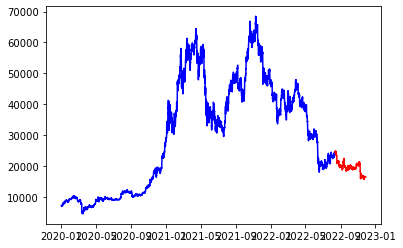

In [8]:
coef_split = 0.90
n_row = int(df.shape[0] * coef_split)
train_data,test_data = df[:n_row],df[n_row:]
plt.plot(train_data,'b')
plt.plot(test_data,'r')

### 2- LSTM : 

https://machinelearningmastery.com/deep-learning-for-time-series-forecasting/

https://github.com/jinglescode/time-series-forecasting-pytorch

https://github.com/Ali619/Bitcoin-Price-Prediction-LSTM/blob/master/Bitcoin_Price_Prediction.ipynb (idée)

In [9]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

#### load 'BTCSDT' close price 

In [10]:
sym,init_date,timeframe = "BTCUSDT","01 January 2020",Client.KLINE_INTERVAL_1DAY
df = get_data(sym,init_date,timeframe)
df.head()
df.shape

(1062, 1)

#### Create the training dataset (np.array, 3dims and saled)

In [11]:
data = df.filter(['close'])
dataset = data.values
training_data_len = math.ceil(len(dataset)*0.8) # We are using %80 of the data for training
training_data_len

850

In [12]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.0382753 ],
       [0.03452661],
       [0.04057276],
       ...,
       [0.18687899],
       [0.18586554],
       [0.18748943]])

We create an array of arrays of the last 60 closes, each elements of them will be inputs.

In [13]:
# Create the training dataset
train_data = scaled_data[0:training_data_len, :]
# Split the data into X_train and y_train data sets
X_train = []
y_train = []

for i in range(60, len(train_data)):
    X_train.append(train_data[i-60: i, 0])
    y_train.append(train_data[i, 0])

[array([0.0382753 , 0.03452661, 0.04057276, 0.04071863, 0.0407926 ,
       0.04715761, 0.05333178, 0.05190812, 0.04811032, 0.05415664,
       0.05133467, 0.05396469, 0.05277475, 0.06392917, 0.06411091,
       0.06249435, 0.06557554, 0.06561826, 0.06220245, 0.06125626,
       0.06274975, 0.06189412, 0.05746468, 0.05801438, 0.05644533,
       0.06082024, 0.06548451, 0.07292387, 0.07176517, 0.07513986,
       0.07258397, 0.07308967, 0.07224313, 0.07161707, 0.07009903,
       0.07671545, 0.07926559, 0.07993087, 0.0812273 , 0.08531972,
       0.08053827, 0.08645689, 0.08810501, 0.08656131, 0.08839038,
       0.08138147, 0.08158154, 0.07821339, 0.08552633, 0.0764245 ,
       0.07646643, 0.07775186, 0.07733433, 0.08188652, 0.07741835,
       0.07199331, 0.06353443, 0.06413961, 0.06206231, 0.05936326])]
[0.05949510751790768]



In [14]:
# Convert the X_train and y_train to numpy array
X_train, y_train = np.array(X_train), np.array(y_train)

In [15]:
# Reshape the data because LSTM needs 3 dim
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) 
X_train.shape

(790, 60, 1)

In [16]:
# Create the testing dataset
# Create a new array containing scaled values from index 2083
test_data = scaled_data[training_data_len - 60 : , :]

#Create the data sets X_test and y_test
X_test = []
y_test = dataset[training_data_len : , :]
for i in range(60, len(test_data)):
    X_test.append(test_data[i-60 : i, 0])
# Convert the data to a numpy array 
X_test = np.array(X_test)
# Reshape the test data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


#### Create the LSTM model:

In [17]:
# Build LSTM model
tf.random.set_seed(42)

model_1 = Sequential()
model_1.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1))) 
model_1.add(LSTM(50, return_sequences=True))
model_1.add(LSTM(50, return_sequences=False))
model_1.add(Dense(25))
model_1.add(Dense(1))

In [18]:
# Compile the model
model_1.compile(optimizer='adam', loss='mse')

In [19]:
# Train the model
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
history = model_1.fit(X_train, y_train, batch_size=1, epochs=5)

Epoch 1/5
790/790 [==============================] - 39s 45ms/step - loss: 0.0071
Epoch 2/5
790/790 [==============================] - 36s 45ms/step - loss: 0.0034
Epoch 3/5
790/790 [==============================] - 24s 30ms/step - loss: 0.0020
Epoch 4/5
790/790 [==============================] - 35s 45ms/step - loss: 0.0017
Epoch 5/5
790/790 [==============================] - 36s 46ms/step - loss: 0.0013


In [20]:
# Get the model_1 predicted price values 
predictions_1 = model_1.predict(X_test)
predictions_1 = scaler.inverse_transform(predictions_1)
print('predictions : ',predictions_1)

predictions :  [[40952.414]
 [40049.535]
 [40029.527]
 [40259.312]
 [39951.445]
 [40786.805]
 [39647.453]
 [38404.58 ]
 [37583.676]
 [36567.176]
 [34086.883]
 [32986.277]
 [31886.957]
 [31213.207]
 [31035.383]
 [31377.48 ]
 [32221.889]
 [32130.889]
 [32022.992]
 [31211.25 ]
 [31282.125]
 [31108.053]
 [31026.678]
 [31390.129]
 [31188.193]
 [31132.994]
 [31106.986]
 [30941.23 ]
 [30555.807]
 [30454.736]
 [30674.188]
 [31880.814]
 [32859.316]
 [32350.57 ]
 [31963.523]
 [31506.83 ]
 [31326.15 ]
 [31343.572]
 [32058.607]
 [32528.79 ]
 [32258.428]
 [31867.568]
 [31194.975]
 [30473.352]
 [29293.732]
 [26883.736]
 [25049.697]
 [24285.936]
 [23342.072]
 [22634.912]
 [21741.592]
 [21568.082]
 [21703.086]
 [21891.36 ]
 [21750.203]
 [21881.59 ]
 [22120.87 ]
 [22377.818]
 [22384.287]
 [22191.123]
 [21851.629]
 [21536.658]
 [21287.809]
 [20929.04 ]
 [20634.76 ]
 [20483.477]
 [20720.875]
 [20992.205]
 [21278.277]
 [21815.232]
 [22247.357]
 [22467.855]
 [22288.773]
 [21743.371]
 [21081.502]
 [20930.01

In [21]:
# Get the root mean squared error (RMSE) for model_1
rmse = np.sqrt(np.mean(predictions_1 - y_test)**2)
rmse

1370.5907075471698

Text(0.5, 0, 'epochs')

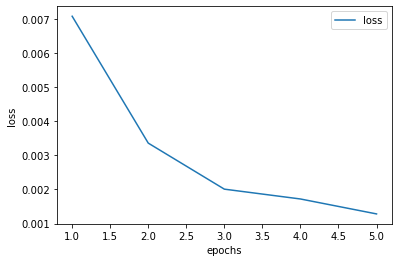

In [22]:
# Let's plot the history of model_1 and see what's going on
historyForPlot = pd.DataFrame(history.history)
historyForPlot.index += 1 # we plus 1 to the number of indexing so our epochs Plot picture will be counting from 1 not 0.
historyForPlot.plot()
plt.ylabel("loss")
plt.xlabel("epochs")

C:\Users\thoma\AppData\Local\Temp/ipykernel_5008/1171132579.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_1['Predictions'] = predictions_1


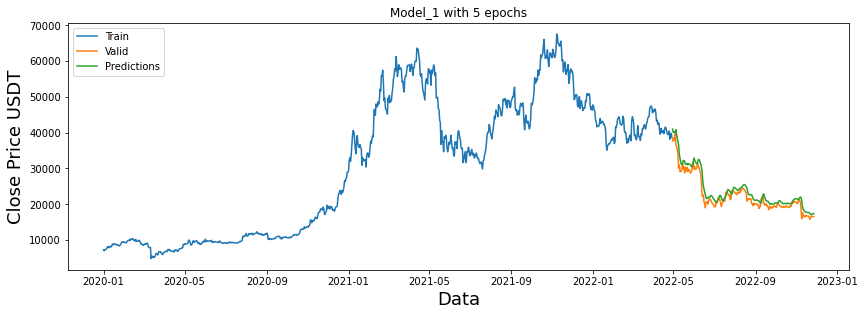

In [43]:
# Plot the data
train = data[:training_data_len]

#data for model_1
valid_1 = data[training_data_len:]
valid_1['Predictions'] = predictions_1


# Visualized the data :
#model_1
plt.figure(figsize=(14, 10))
plt.subplot(2, 1, 1)
plt.title('Model_1 with 5 epochs')
plt.xlabel('Data', fontsize=18)
plt.ylabel('Close Price USDT', fontsize=18)
plt.plot(train)
plt.plot(valid_1[['close', 'Predictions']])

plt.legend(['Train', 'Valid', 'Predictions'], loc='upper left')

In [13]:
def signal(actual_price,pred):
    if(pred> actual_price): return 1
    else: return -1

In [14]:
signal(1,2)

1

In [30]:
def pred_on_k_days(fitted_model,data,k):
    predictions = []
    RSME=0
    print(data.index[-k-1])
    print('actual_price : ',data['close'][-k-1],'\n')
    for i in range(k):
        if(i==0):
            last_60_days = data[-60:].values
        else:
            last_60_days = data[-(60+i):-i].values
        last_60_days_scaled = scaler.fit_transform(last_60_days)
        new_X_test = []
        new_X_test.append(last_60_days_scaled)
        new_X_test = np.array(new_X_test)
        new_X_test = np.reshape(new_X_test, (new_X_test.shape[0], new_X_test.shape[1], 1))
        pred_price = fitted_model.predict(new_X_test)
        pred_price = np.array(scaler.inverse_transform(pred_price))
        np.append(last_60_days,pred_price)
        print(data.index[-k+i])
        print('pred : ',pred_price[0][0])
        print('actual_price : ',data['close'][-k+i])
        print()
        RSME+= (pred_price[0][0]-data['close'][-k+i])**2
        
    RSME = math.sqrt((1/k*RSME))
    print(RSME)
    return last_60_days[-k:]
    
    

In [31]:
pred3 = pred_on_k_days(model_1,data,3)

2022-11-24 01:00:00
actual_price :  16598.95 

2022-11-25 01:00:00
pred :  16610.25
actual_price :  16522.14

2022-11-26 01:00:00
pred :  16601.764
actual_price :  16458.57

2022-11-27 01:00:00
pred :  16583.975
actual_price :  16560.43

98.0172576567798


#### Tuning the hyperparameters :

In [32]:
from keras_tuner.tuners import RandomSearch

In [79]:
def model_1(hp):
    model_1 = Sequential()
    model_1.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1))) 
    model_1.add(LSTM(50, return_sequences=False))
    model_1.add(Dense(25))
    model_1.add(Dense(1))
    model_1.compile(loss='mse')
    return model_1

In [80]:
tuner = RandomSearch(model_1,
        objective='val_loss',  #loss
        max_trials=2,
        overwrite=True,
        executions_per_trial=1)

In [81]:
tuner.search(
        x=X_train,
        y= y_train,
        epochs=10,
        batch_size=128,
        validation_data=(X_test,y_test)
        
)

Trial 1 Complete [00h 00m 13s]
val_loss: 536242912.0

Best val_loss So Far: 536242912.0
Total elapsed time: 00h 00m 13s
INFO:tensorflow:Oracle triggered exit


In [82]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model = tuner.hypermodel.build(best_model)

In [83]:
predictions_best_model = best_model.predict(X_test)
predictions_best_model  = scaler.inverse_transform(predictions_best_model )

C:\Users\thoma\AppData\Local\Temp/ipykernel_5008/2274235045.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions_best_model


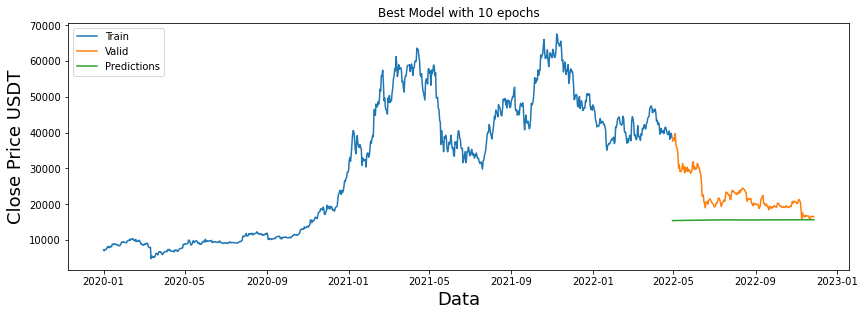

In [84]:
# Plot the data
train = data[:training_data_len]

#data for model_1
valid = data[training_data_len:]
valid['Predictions'] = predictions_best_model


# Visualized the data :
#model_1
plt.figure(figsize=(14, 10))
plt.subplot(2, 1, 1)
plt.title('Best Model with 10 epochs')
plt.xlabel('Data', fontsize=18)
plt.ylabel('Close Price USDT', fontsize=18)
plt.plot(train)
plt.plot(valid[['close', 'Predictions']])

plt.legend(['Train', 'Valid', 'Predictions'], loc='upper left')

In [59]:
valid

,close,Predictions
date,,
2022-04-30 02:00:00,37630.80,18902.720703
2022-05-01 02:00:00,38468.35,18851.105469
2022-05-02 02:00:00,38525.16,18835.437500
2022-05-03 02:00:00,37728.95,18835.919922
2022-05-04 02:00:00,39690.00,18815.185547
...,...,...
2022-11-23 01:00:00,16603.11,16737.550781
2022-11-24 01:00:00,16598.95,16743.517578
2022-11-25 01:00:00,16522.14,16752.724609


Idées:

-faire une pred sur 3 jours


-ajouter le volume et ou open etc


-changer le nb de layers, inputs(60?) etc


-tester sur l'ETHUSDT